In [1]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=18)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import pandas as pd
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import copy as cp
from typing import Tuple
from sklearn.metrics import confusion_matrix
import json
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline   
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2
import os
import auxiliary as aux_func
from pathlib import Path
import math
import pickle
import lightgbm as lgb
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
CAL_TYPE = 'slice'
import glob
import shap
import nibabel as nib

# MODEL_TYPE='weak'
# MODEL_TYPE='ct3d'
# MODEL_TYPE='ct2d'
# MODEL_TYPE='spm12'
MODEL_TYPE='spm12contour'
# FEATURE_TYPE='AVG'
FEATURE_TYPE='TOP'


In [2]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

In [3]:
SEARCH_PATH = '../../data4-4tb/kgreathoo/dataset_norm_mask_by_revisited'
nph_files = glob.glob(SEARCH_PATH + '/normal/*/s/*', recursive=True)
NPH = []
for i in nph_files:
    NPH.append(i.split('/')[-1])

In [4]:
def CalculatePerSlice(fold_idx,SEARCH_PATH,df,range_slice,model=None,exclude0=True):
    '''
    read numpy array instead search path
    '''
    
    
    for file in glob.glob(SEARCH_PATH, recursive=True):
        label=0
        masks = nib.load(file).get_fdata()
        masks = masks.astype('int16')
        
        width, height, slices = masks.shape
        amount_slices=math.ceil(slices/range_slice)
        if exclude0:
            slice_mask = np.arange(amount_slices, slices)
        else:
            slice_mask = np.arange(slices)
            
        if model != 'ct2d' and model != 'ct3d':
            CSF_C = 1
            BRAIN_C = 2
            n_csfs = np.count_nonzero(masks[:, :, slice_mask]  == CSF_C)
            n_brains = np.count_nonzero(masks[:, :, slice_mask]  == BRAIN_C)
            
        elif model == 'ct2d':
            n_csfs = np.count_nonzero((masks[:, :, slice_mask]  == 10) | (masks[:,:,slice_mask] == 2))
            n_brains = np.count_nonzero((masks[:, :, slice_mask]  != 10) & (masks[:,:,slice_mask] != 2))
        elif model == 'ct3d':
            n_csfs = np.count_nonzero((masks[:, :, slice_mask]  == 1) | (masks[:,:,slice_mask] == 3))
            n_brains = np.count_nonzero((masks[:, :, slice_mask]  != 1) & (masks[:,:,slice_mask] != 3))
        
        whole_csf_ratio = n_csfs / (n_csfs + n_brains)
        whole_csf_brain = n_csfs / n_brains
        
        whole_csf_brain_sum=0
        ratios = np.zeros(slices, dtype=np.float32)
        ratios_brain= np.zeros(slices, dtype=np.float32)
        relatives = np.zeros(slices, dtype=np.float32)
        sid = file.split('-')[0]
        amount_slices=math.ceil(slices/range_slice)
        
        index=0
        whole_csf=0
        whole_brain=0
        csfs = 0
        brains = 0
        for i in range(0,slices,amount_slices):
            csfs = 0
            brains = 0
            
            stat_csf_ratio=np.zeros(amount_slices, dtype=np.float32)
            stat_csf_brain_ratio=np.zeros(amount_slices, dtype=np.float32)
            for j in range(amount_slices):
                if i+j>=slices-1:
                    break
                if model:
                    if model == 'ct2d':
                        csfs += np.count_nonzero((masks[:,:,i+j] == 10) | (masks[:,:,i+j] == 2))
                        brains += np.count_nonzero((masks[:,:,i+j] != 10) & (masks[:,:,i+j] != 2))
                    
                    elif model == 'ct3d':
                        csfs += np.count_nonzero((masks[:,:,i+j] == 1) | (masks[:,:,i+j] == 3))
                        brains += np.count_nonzero((masks[:,:,i+j] != 1) & (masks[:,:,i+j] != 3))
                else:
                    csfs += np.count_nonzero(masks[:,:,i+j] == 1)
                    brains += np.count_nonzero(masks[:,:,i+j] == 2)
                if brains + csfs ==0 or brains ==0:
                    stat_csf_ratio[j]=0
                    stat_csf_brain_ratio[j]=0
                else:
                    stat_csf_ratio[j]=csfs / (brains + csfs)
                    stat_csf_brain_ratio[j]=csfs / brains
            whole_csf+=csfs
            whole_brain+=brains
            total = brains + csfs
            if total == 0:
                ratios[i] = 0
                ratios_brain[i] = 0
            else:
                ratios[i] = csfs / total
                ratios_brain[i] = brains/total
            if csfs == 0 or brains == 0:
                relatives[i] = np.nan
                whole_csf_brain_sum+=0
            else:
                relatives[i] = csfs / brains
                whole_csf_brain_sum+=csfs / brains


            a_row = {
                        "PatientID" : file.split('/')[-1],
                "HN":file.split('/')[-1].split('-')[0].split('s')[1],
                        'filename':file,
                        f"Mean CSF ratio_{index}" : np.mean(stat_csf_ratio),
                        f"Max CSF ratio_{index}" : np.max(stat_csf_ratio),
                        f"Min CSF ratio_{index}" : np.min(stat_csf_ratio),
                        f"Std CSF ratio_{index}" : np.std(stat_csf_ratio),
                        f"CSF ratio_{index}" : ratios[i],
                        f"Brain ratio_{index}" : ratios_brain[i],
                        f'Mean CSF / W+G matter ratio_{index}':np.mean(stat_csf_ratio),
                        f'Max CSF / W+G matter ratio_{index}':np.max(stat_csf_ratio),
                        f'Min CSF / W+G matter ratio_{index}':np.min(stat_csf_ratio),
                        f'Std CSF / W+G matter ratio_{index}':np.std(stat_csf_ratio),
                        f'CSF / W+G matter ratio_{index}':relatives[i],
                        f"CSF_ratio_all" : whole_csf_ratio,
                        f"CSF / W+G matter ratio_all" : whole_csf_brain,
                "fold":fold_idx

                    }
            index+=1
            
            df = pd.concat([df, pd.DataFrame([a_row])], ignore_index=True)
    return df



In [5]:
'''
set path depend on type of model
'''

def createDFofperslice(range_slice,model=None):
    df = pd.DataFrame()
    num_fold = 1
    if model=='weak':
        num_fold = 5
    for i in range(num_fold):
        print(i)
        if model == 'weak':
            file_nii = f'/data2-2tb/kgreathoo/saved_img/nii_42_focalloss_200epochs_lr_init=0.001_unet_scaled_(0,40)(0,20)(20,40)_224_allSlice_byTime_fold{i}/**.nii'
        else:
            if model == 'ct3d':
                file_nii = f'/data4-4tb/kgreathoo/NPH_Prediction/UNet_Outputs/**1.nii'
            elif model == 'ct2d':
                file_nii = f'/data4-4tb/kgreathoo/HeadCTSegmentation/results_folder/**_MODEL_PREDICT/Prediction_s**.nii'
            elif model == 'spm12':
                file_nii = f'/data4-4tb/kgreathoo/dataset_norm_mask_by_revisited/**/**/segment_mask_confidence1/**.nii'
            elif model == 'spm12contour':
                file_nii = f'/data4-4tb/kgreathoo/dataset_norm_mask_by_revisited/**/**/segment_mask_confidence1_contour/**.nii'
        df=CalculatePerSlice(i,file_nii,df,range_slice,exclude0=False)    
    return df  

In [6]:
tmp = createDFofperslice(10,model=MODEL_TYPE)
data = tmp.groupby(['PatientID','HN', 'fold'], sort=True).max(numeric_only=True).reset_index()

0


In [8]:
if CAL_TYPE!='head':
    cols=[]
    for i in range(10):
        cols.append(f'CSF ratio_{i}')     
        cols.append(f'CSF / W+G matter ratio_{i}')
        cols.append(f"Mean CSF ratio_{i}")
        cols.append(f"Min CSF ratio_{i}")
        cols.append(f"Max CSF ratio_{i}")
        cols.append(f"Std CSF ratio_{i}")
        cols.append(f"Mean CSF / W+G matter ratio_{i}")
        cols.append(f"Min CSF / W+G matter ratio_{i}")
        cols.append(f"Max CSF / W+G matter ratio_{i}")
        cols.append(f"Std CSF / W+G matter ratio_{i}")
    cols.append('CSF_ratio_all')
    cols.append('CSF / W+G matter ratio_all')

data['y'] = np.where((data['PatientID']).isin(NPH), 0, 1)
data['CSF_ratio_sum_all'] = data[[f'CSF ratio_{i}' for i in range(10)]].sum(axis=1)/10
data['CSF / W+G matter ratio_sum_all'] = data[[f'CSF / W+G matter ratio_{i}' for i in range(10)]].sum(axis=1)/10

mismatch = pd.read_csv('p_pun_217.csv')
mismatch['HN'] = mismatch['HN'].astype(str)
merged_df = pd.merge(data[['HN', 'y']], mismatch[['HN', 'y']], on='HN', suffixes=('_data', '_mismatch'))
diff_df = merged_df[merged_df['y_data'] != merged_df['y_mismatch']]
hn_list = diff_df['HN'].tolist()
mask = data['HN'].isin(hn_list)
data.loc[mask, 'y'] = 0

In [9]:
data['y'].value_counts()

1    337
0    112
Name: y, dtype: int64

In [10]:
data

,PatientID,HN,fold,Mean CSF ratio_0,Max CSF ratio_0,Min CSF ratio_0,Std CSF ratio_0,CSF ratio_0,Brain ratio_0,Mean CSF / W+G matter ratio_0,...,CSF ratio_9,Brain ratio_9,Mean CSF / W+G matter ratio_9,Max CSF / W+G matter ratio_9,Min CSF / W+G matter ratio_9,Std CSF / W+G matter ratio_9,CSF / W+G matter ratio_9,y,CSF_ratio_sum_all,CSF / W+G matter ratio_sum_all
0,s38000954-0002-00001-000001.nii,38000954,0,0.000017,0.000254,0.000000,0.000063,0.000254,0.999746,0.000017,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,1,0.254459,0.419581
1,s38001603-0002-00001-000001.nii,38001603,0,0.366402,0.830330,0.000000,0.356920,0.830330,0.169670,0.366402,...,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,1,0.448554,11.451827
2,s38003871-0301-00001-000001.nii,38003871,0,0.537191,0.999036,0.000000,0.497344,0.998387,0.001613,0.537191,...,0.268010,0.731990,0.214009,0.348402,0.0,0.119110,0.366139,1,0.357802,62.335615
3,s38003904-0002-00001-000001.nii,38003904,0,0.680163,0.971926,0.000000,0.400600,0.703354,0.296646,0.680163,...,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,NaN,1,0.240521,0.473107
4,s38004023-0301-00001-000001.nii,38004023,0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,0,0.407731,0.641825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,s54279570-0301-00001-000001.nii,54279570,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,0,0.288703,1.073356
445,s54283571-0301-00001-000001.nii,54283571,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.186686,0.813314,0.164712,0.266780,0.0,0.073326,0.229537,0,0.119079,0.166737
446,s54288410-0301-00001-000001.nii,54288410,0,0.626585,0.971228,0.000000,0.373918,0.581800,0.418200,0.626585,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,0,0.168702,0.290221
447,s54354537-0002-00001-000001_pre_fix_ge_ct.nii,54354537,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.380845,0.619155,0.318128,0.562912,0.0,0.182092,0.615105,1,0.301338,0.814338


# Create 5-fold cv

In [11]:
train_test_folds = json.load(open('folds5_42_val.json'))

folds={}
num_fold=5
for fold_idx in range(num_fold):
    folds[fold_idx] = {
        'train':[i.split('/')[-1].split('-')[0].split('s')[1][0:10] for i in train_test_folds[str(fold_idx)]['train']],
        'test':[i.split('/')[-1].split('-')[0].split('s')[1][0:10]  for i in train_test_folds[str(fold_idx)]['test']],
        'val':[i.split('/')[-1].split('-')[0].split('s')[1][0:10]  for i in train_test_folds[str(fold_idx)]['val']],
    }
    fold_idx+=1

In [16]:
data['type'] = None

for fold_idx in range(num_fold):
    data['type'] = np.where((data['fold'] == int(fold_idx)) & data['HN'].isin(folds[fold_idx]['train']), f'train{fold_idx}', data['type'])
    data['type'] = np.where((data['fold'] == int(fold_idx)) & data['HN'].isin(folds[fold_idx]['test']), f'test{fold_idx}', data['type'])


In [17]:
data.drop_duplicates(subset=['HN','fold'], inplace=True)
data.fillna(0, inplace=True)

In [18]:
cols = data.drop(columns=['PatientID','HN','fold','y','type']).columns.values
print(cols)

['Mean CSF ratio_0' 'Max CSF ratio_0' 'Min CSF ratio_0' 'Std CSF ratio_0'
 'CSF ratio_0' 'Brain ratio_0' 'Mean CSF / W+G matter ratio_0'
 'Max CSF / W+G matter ratio_0' 'Min CSF / W+G matter ratio_0'
 'Std CSF / W+G matter ratio_0' 'CSF / W+G matter ratio_0' 'CSF_ratio_all'
 'CSF / W+G matter ratio_all' 'Mean CSF ratio_1' 'Max CSF ratio_1'
 'Min CSF ratio_1' 'Std CSF ratio_1' 'CSF ratio_1' 'Brain ratio_1'
 'Mean CSF / W+G matter ratio_1' 'Max CSF / W+G matter ratio_1'
 'Min CSF / W+G matter ratio_1' 'Std CSF / W+G matter ratio_1'
 'CSF / W+G matter ratio_1' 'Mean CSF ratio_2' 'Max CSF ratio_2'
 'Min CSF ratio_2' 'Std CSF ratio_2' 'CSF ratio_2' 'Brain ratio_2'
 'Mean CSF / W+G matter ratio_2' 'Max CSF / W+G matter ratio_2'
 'Min CSF / W+G matter ratio_2' 'Std CSF / W+G matter ratio_2'
 'CSF / W+G matter ratio_2' 'Mean CSF ratio_3' 'Max CSF ratio_3'
 'Min CSF ratio_3' 'Std CSF ratio_3' 'CSF ratio_3' 'Brain ratio_3'
 'Mean CSF / W+G matter ratio_3' 'Max CSF / W+G matter ratio_3'
 'Min CSF

# Features selection

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import lightgbm as lgb

# Assuming you have already loaded your data and defined the "cols" variable

# Fit an ExtraTreesClassifier model to your data
X = data[data['type'] == 'train0'][cols].to_numpy()
y = data[data['type'] == 'train0']['y'].to_numpy()
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)

# Get the feature importances and sort them in descending order
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

# Create a new dataframe to store the feature ranks
feature_rank = pd.DataFrame(columns=['feature', 'score', 'method'])

# Loop through the sorted indices and add each feature's rank to the dataframe
for i, idx in enumerate(sorted_idx):
    feature_name = cols[idx]
    score = importances[idx]
    method = 'ExtraTreesClassifier'
    feature_rank.loc[i] = [feature_name, score, method]

# Train a LightGBM model
X_train = data[data['type'] == 'train0'][cols]
y_train = data[data['type'] == 'train0']['y']
print()
train_data = lgb.Dataset(X_train, label=y_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_depth':1
}
num_round = 100
model = lgb.train(params, train_data, num_round)

# Get the feature importances and sort them in descending order
importances = model.feature_importance()
feature_names = model.feature_name()
sorted_idx = importances.argsort()[::-1]

# Loop through the sorted indices and add each feature's rank to the dataframe
for i, idx in enumerate(sorted_idx):
    feature_name = cols[idx]
    score = importances[idx]
    method = 'LightGBM'
    feature_rank.loc[i+len(feature_rank)] = [feature_name, score, method]

# Split your data into training and test sets (if you haven't already)
X_train = data[data['type'] == 'train0'][cols].to_numpy()
y_train = data[data['type'] == 'train0']['y'].to_numpy()

# Fit a SelectKBest model to your training data
bestfeatures = SelectKBest(score_func=f_classif, k=2)
fit = bestfeatures.fit(X_train, y_train)

# Get the feature importances and sort them in descending order
scores = fit.scores_
sorted_idx = np.argsort(scores)[::-1]

# Loop through the sorted indices and add each feature's rank to the dataframe
for i, idx in enumerate(sorted_idx):
    feature_name = cols[idx]
    score = scores[idx]
    method = 'SelectKBest with f_classif'
    feature_rank.loc[i+len(feature_rank)] = [feature_name, score, method]



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


Features [103 109] are constant.
invalid value encountered in true_divide


# select top rank by k of each method

In [20]:
# Create a dictionary to store the dataframes for each method
method_dfs = {}

# Loop through each unique method in the feature_rank dataframe
for method in feature_rank['method'].unique():
    # Select only the rows with the current method
    method_rows = feature_rank[feature_rank['method'] == method]
    # Sort the rows by score in descending order
    method_rows = method_rows.sort_values(by='score', ascending=False)
    # Add the sorted dataframe to the dictionary
    method_rows['index'] = method_rows.index
    # Update the method DataFrame in the dictionary with the new 'index' column
    method_dfs[method] = method_rows
    
# Example usage: print the top 10 features for the ExtraTreesClassifier method
if FEATURE_TYPE=='TOP':
    n=10
    feature_top = method_dfs['ExtraTreesClassifier'].head(n)
    # feature_top = method_dfs['LightGBM'].head(n)
    # feature_top = method_dfs['SelectKBest with f_classif'].head(n)
    cols = feature_top['feature'].values

# select k top rank of all methods

In [21]:
for method in method_dfs:
    # Select only the rows with the current method
    method_rows = method_dfs[method]
    # Reset the index of the DataFrame to start at 0
    method_rows = method_rows.reset_index(drop=True)
    # Add a new key 'index' to the current method DataFrame
    method_rows['index'] = method_rows.index
    # Update the method DataFrame in the dictionary with the new 'index' column
    method_dfs[method] = method_rows

top_features = {}
if FEATURE_TYPE=='AVG':
    n=10
    for method in method_dfs:
        top_features[method] = set(method_dfs[method].head(n)['feature'])

    # Get the intersection of all top 100 feature sets
    common_features = set.intersection(*top_features.values())

    # Print the common features
    cols =common_features

In [23]:
print(FEATURE_TYPE)
cols

TOP


array(['CSF / W+G matter ratio_8', 'Mean CSF / W+G matter ratio_4',
       'Max CSF / W+G matter ratio_4', 'Std CSF / W+G matter ratio_3',
       'Brain ratio_9', 'Mean CSF / W+G matter ratio_5', 'CSF ratio_4',
       'CSF ratio_5', 'Min CSF / W+G matter ratio_7', 'CSF ratio_3'],
      dtype=object)

# train model

[LightGBM] [Info] Number of positive: 313, number of negative: 87
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1251
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
  0	0.78000		0.70455
[LightGBM] [Info] Number of positive: 310, number of negative: 90
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1254
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
  1	0.7

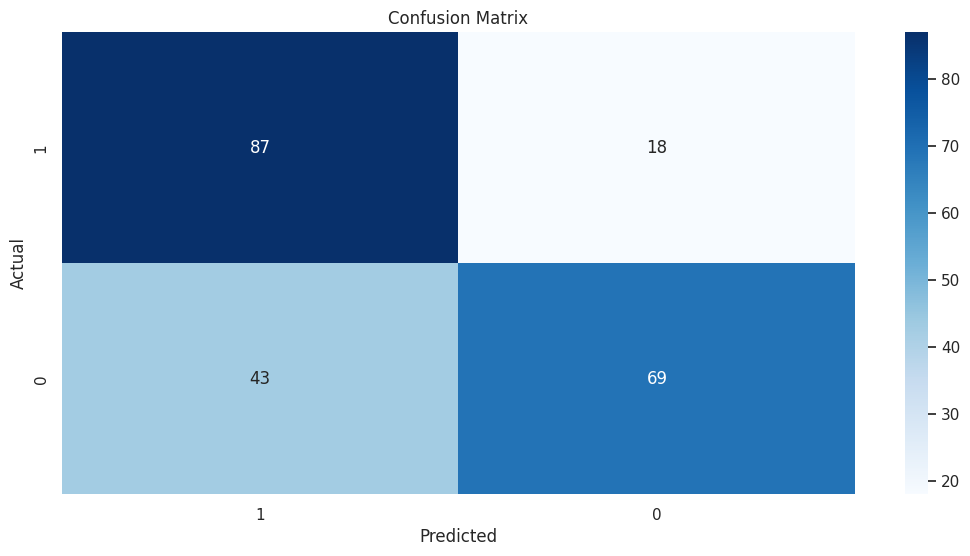

In [28]:
from datetime import datetime

# model_train='lr'
# model_train='RF'
model_train='light'
y_true = []
y_pred = []
y_prob = []
X=data[cols].to_numpy()
y=data['y']
Y=y.astype('int')
score_train=[]
score_test=[]
xx, yy = np.mgrid[-1:1.1:.01, -1:1.1:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
save_idx=[]
pred_df = pd.DataFrame()
for fold_idx in range(5):
    pred_df_tmp = pd.DataFrame()
    if MODEL_TYPE == 'weak' :
        print('weak :')
        
        data['type'] = None
        data['type'] = np.where((data['fold'] == int(fold_idx)) & data['HN'].isin(folds[fold_idx]['train']), f'train{fold_idx}', data['type'])
        data['type'] = np.where((data['fold'] == int(fold_idx)) & data['HN'].isin(folds[fold_idx]['test']), f'test{fold_idx}', data['type'])

    else:
        data['type']=None
        data['type'] = np.where(data['HN'].isin(folds[fold_idx]['train']), f'train{fold_idx}', data['type'])
        data['type'] = np.where(data['HN'].isin(folds[fold_idx]['test']), f'test{fold_idx}',data['type'])
        data['type'] = np.where(data['HN'].isin(folds[fold_idx]['val']), f'val{fold_idx}', data['type'])
        
        data['type'] = data.apply(lambda row: None if (row['type'] == f'test{fold_idx}' and row['HN'] in folds[fold_idx]['train']) else row['type'], axis=1)

    X_train = data[(data['type']==f'train{fold_idx}') | (data['type']==f'val{fold_idx}')][cols].to_numpy()
    y_train = data[(data['type']==f'train{fold_idx}') | (data['type']==f'val{fold_idx}')]['y'].to_numpy()
    X_test = data[data['type']==f'test{fold_idx}'][cols].to_numpy()
    y_test = data[data['type']==f'test{fold_idx}']['y'].to_numpy()

    test = train_test_folds['{}'.format(fold_idx)]['test']
    save_idx.append(data.index[data['type']==f'test{fold_idx}'].tolist())
    pred_df_tmp['HN'] =data[data['type']==f'test{fold_idx}']['HN']
    pred_df_tmp['y']=data[data['type']==f'test{fold_idx}']['y']
    
    if(model_train=='lr'):
        C=100
        model2 = LogisticRegression(class_weight="balanced", C=C,solver='lbfgs' ,max_iter=10000)
        model2 = LogisticRegression(C=C).fit(X_train, y_train)
    elif(model_train=='RF'):
        model2 = RandomForestClassifier(class_weight="balanced",n_estimators=5)
        model2.fit(X_train, y_train)
    elif(model_train=='light'):
#         num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, 
        model2 = lgb.LGBMClassifier(class_weight="balanced",num_leaves=2, max_depth=1)
        model2.fit(X_train, y_train)
    print("%3d\t%.5f\t\t%.5f" % 
          (fold_idx, model2.score(X_train, y_train), model2.score(X_test, y_test)))
    score_train.append(model2.score(X_train, y_train))
    score_test.append(model2.score(X_test, y_test))
    
    y_true.extend(y_test)
    y_pred.extend(model2.predict(X_test))
    y_prob.extend(model2.predict_proba(X_test))
    pickle.dump(model2, open(f'ClassifyModel_{datetime.today().strftime("%Y-%m-%d")}_{fold_idx}.sav', 'wb'))
#     pickle.dump(model2, open(f'SPM12confident1contour{fold_idx}.sav', 'wb'))
#     pickle.dump(model2, open(f'SPM12confident1{fold_idx}.sav', 'wb'))
#     pickle.dump(model2, open(f'headCT2023v2{fold_idx}.sav', 'wb'))
#     pickle.dump(model2, open(f'ct3d{fold_idx}.sav', 'wb'))

    pred_df = pd.concat([pred_df, pred_df_tmp], ignore_index=True)
pred_df['y_pred_model']=y_pred

# if(model_train=='lr'):
#     explainer = shap.LinearExplainer(model2, X_train, feature_perturbation="interventional")
#     shap_values = explainer(data[cols])
#     shap.plots.beeswarm(shap_values, max_display=200)
# elif(model_train=='RF'):
#     explainer = shap.TreeExplainer(model2)
#     shap_values = explainer(X_test)
#     shap_values = explainer.shap_values(data[cols]) 
#     shap.summary_plot(shap_values[1], data[cols]) 
# elif(model_train=='light'):
#     explainer = shap.TreeExplainer(model2, X_train, feature_perturbation="interventional")
#     shap_values = explainer(data[cols])
#     shap.plots.beeswarm(shap_values, max_display=200)

print('Accuracy: %.3f (%.3f)' % (mean(score_test), std(score_test)))
y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred)
y_prob = np.asarray(y_prob)
confusion_matrix(y_true, y_pred, labels=[0, 1])
logit_roc_auc = roc_auc_score(y_true, y_pred)
fpr, tpr, thresholds = roc_curve(y_true, y_prob[:,1])
cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred), f' (area = %0.2f)' % logit_roc_auc)
from sklearn.metrics import cohen_kappa_score
print('cohen',cohen_kappa_score(y_true, y_pred))

plot_confusion_matrix(y_true, y_pred, [1, 0])

# Compare with Doctor confident group

In [25]:
from sklearn.metrics import confusion_matrix, f1_score

pred_df['HN'] = pred_df['HN'].astype(str)
doctor = pd.read_csv('Pre_Analyze_NPH_21012023.csv')

    
def predict_nph(score):
    if 3 <= score <= 4:
        return -1
    return score/12 >=0.5

pred_df = pred_df
# Apply the function to the 'Total score' column to create a new 'Predicted NPH' column
doctor['Predicted NPH'] = doctor['Total score (12)'].apply(predict_nph)
doctor['HN']=doctor['HN'].astype(int).astype(str)
pred_df['HN']=pred_df['HN'].str[0:8]
merged_df = pd.merge(doctor, pred_df, on='HN', how='left')
merged_df= merged_df[['HN','Predicted NPH','y_pred_model','Clinical (NPH 1 normal 0)']]
# merged_df= merged_df[['HN','Predicted NPH','y_pred','Clinical (NPH 1 normal 0)']]
filtered_doctor = merged_df[merged_df['Predicted NPH'] != -1]
model = pd.DataFrame()
doctor_score= pd.DataFrame()
model[['y','y_pred','HN']]=filtered_doctor[['Clinical (NPH 1 normal 0)','y_pred_model','HN']]
doctor_score[['y','y_pred']]=filtered_doctor[['Clinical (NPH 1 normal 0)','Predicted NPH']]
model=model.dropna()
# Drop rows with null values in 'y' or 'y_pred' columns
doctor_score.dropna(subset=['y', 'y_pred'], inplace=True)

# Ensure that 'y_pred' is an integer
model['y_pred'] = model['y_pred'].astype('int')
y_true = model['y']
y_pred = model['y_pred']

confusion_mat = confusion_matrix(y_true, y_pred, labels=[0, 1])
logit_roc_auc = roc_auc_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_true, y_pred), f' (area = {logit_roc_auc:.2f})')
print('cohen',cohen_kappa_score(y_true, y_pred))

model = pd.DataFrame()
doctor_score= pd.DataFrame()
model[['y','y_pred','HN']]=filtered_doctor[['Clinical (NPH 1 normal 0)','y_pred_model','HN']]
doctor_score[['y','y_pred']]=filtered_doctor[['Clinical (NPH 1 normal 0)','Predicted NPH']]
model=model.dropna()
# Drop rows with null values in 'y' or 'y_pred' columns
doctor_score.dropna(subset=['y', 'y_pred'], inplace=True)

Confusion Matrix:
[[65 28]
 [16 71]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.75        93
           1       0.72      0.82      0.76        87

    accuracy                           0.76       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.76      0.76      0.76       180
  (area = 0.76)
cohen 0.512735326688815


# Compare with Doctor borderline group

In [26]:
from sklearn.metrics import confusion_matrix, f1_score

doctor = pd.read_csv('Pre_Analyze_NPH_21012023.csv')

    
def predict_nph(score):
    if 3 <= score <= 4:
        return -1
    return score/12 >=0.5

pred_df = pred_df
# Apply the function to the 'Total score' column to create a new 'Predicted NPH' column
doctor['Predicted NPH'] = doctor['Total score (12)'].apply(predict_nph)
doctor['HN']=doctor['HN'].astype(int).astype(str)
pred_df['HN']=pred_df['HN'].str[0:8]
merged_df = pd.merge(doctor, pred_df, on='HN', how='left')
merged_df= merged_df[['HN','Predicted NPH','y_pred_model','Clinical (NPH 1 normal 0)']]
# merged_df= merged_df[['HN','Predicted NPH','y_pred','Clinical (NPH 1 normal 0)']]
filtered_doctor = merged_df[merged_df['Predicted NPH'] == -1]
model = pd.DataFrame()
doctor_score= pd.DataFrame()
model[['y','y_pred','HN']]=filtered_doctor[['Clinical (NPH 1 normal 0)','y_pred_model','HN']]
doctor_score[['y','y_pred']]=filtered_doctor[['Clinical (NPH 1 normal 0)','Predicted NPH']]
model=model.dropna()
# Drop rows with null values in 'y' or 'y_pred' columns
doctor_score.dropna(subset=['y', 'y_pred'], inplace=True)

# Ensure that 'y_pred' is an integer
model['y_pred'] = model['y_pred'].astype('int')
y_true = model['y']
y_pred = model['y_pred']

confusion_mat = confusion_matrix(y_true, y_pred, labels=[0, 1])
logit_roc_auc = roc_auc_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_true, y_pred), f' (area = {logit_roc_auc:.2f})')
print('cohen',cohen_kappa_score(y_true, y_pred))

model = pd.DataFrame()
doctor_score= pd.DataFrame()
model[['y','y_pred','HN']]=filtered_doctor[['Clinical (NPH 1 normal 0)','y_pred_model','HN']]
doctor_score[['y','y_pred']]=filtered_doctor[['Clinical (NPH 1 normal 0)','Predicted NPH']]
model=model.dropna()
# Drop rows with null values in 'y' or 'y_pred' columns
doctor_score.dropna(subset=['y', 'y_pred'], inplace=True)

Confusion Matrix:
[[ 4 15]
 [ 2 16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.21      0.32        19
           1       0.52      0.89      0.65        18

    accuracy                           0.54        37
   macro avg       0.59      0.55      0.49        37
weighted avg       0.59      0.54      0.48        37
  (area = 0.55)
cohen 0.09756097560975618
